In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skfda.representation.basis import BSpline
from skfda.representation import FDataGrid, FDataBasis


In [2]:
train = pd.read_csv(f'ECG5000_TRAIN.arff', header=None)
test = pd.read_csv(f'ECG5000_TEST.arff', header=None)
y_train = train.iloc[:, -1]  -1
# y_train = [1 if i == 1 else 0 for i in y_train]
y_train

0      0
1      0
2      0
3      0
4      0
      ..
495    3
496    3
497    3
498    4
499    4
Name: 140, Length: 500, dtype: int64

# Functional Data Analysis: A solution to the Curse of Dimensionality

This notebook is a companion to the medium article. The dataset can be found [here](https://physionet.org/content/chfdb/1.0.0/), and the processed version [here](https://timeseriesclassification.com/description.php?Dataset=ECG5000)

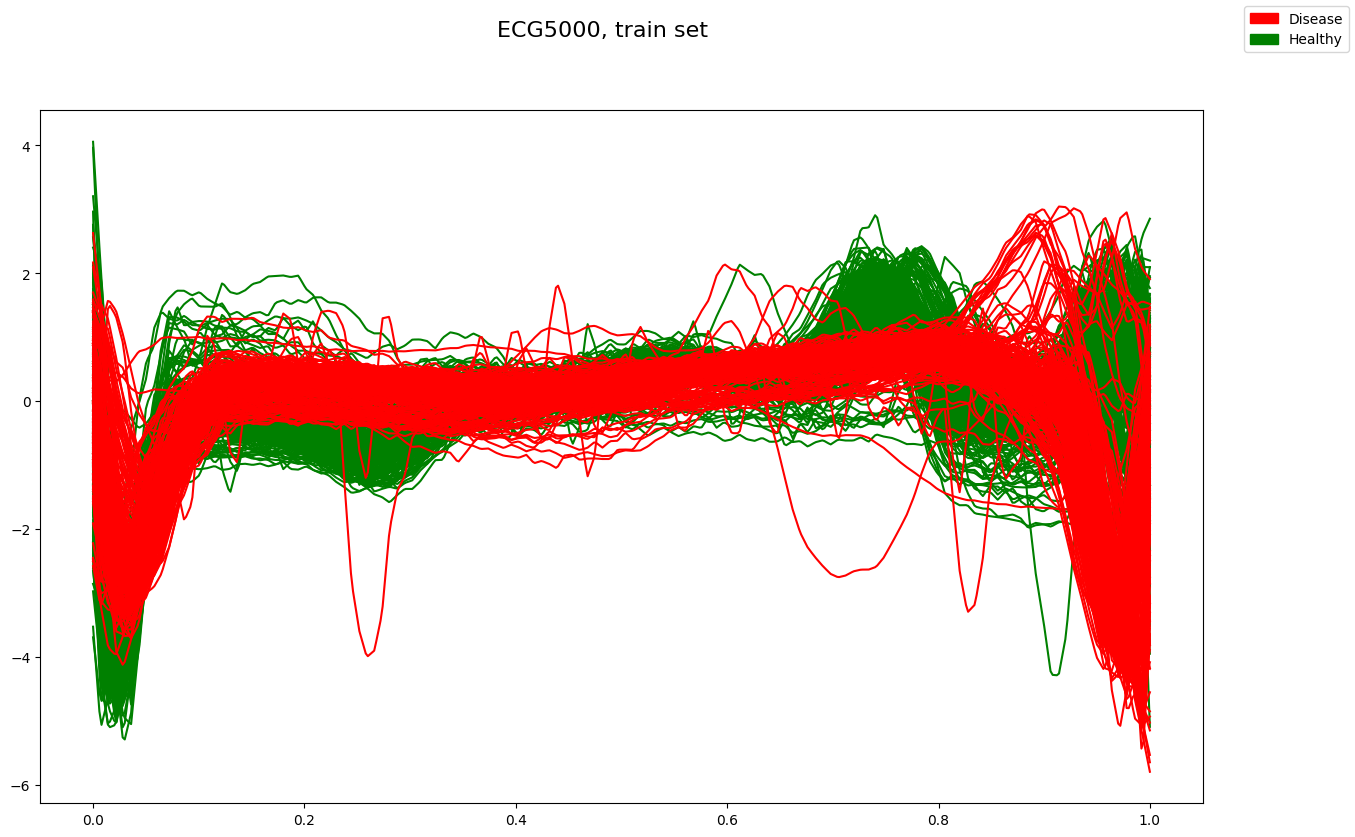

In [3]:
train = pd.read_csv(f'ECG5000_TRAIN.arff', header=None)
test = pd.read_csv(f'ECG5000_TEST.arff', header=None)
y_train = train.iloc[:, -1] 
y_train = [1 if i == 1 else 0 for i in y_train]
X_train = train.iloc[:, :-1]
y_test = test.iloc[:, -1] 
y_test = [1 if i == 1 else 0 for i in y_test]
X_test = test.iloc[:, :-1]

X_train_plot = FDataGrid(X_train)
fig = plt.figure(figsize=(15, 9), dpi = 100)

X_train_plot.plot(fig = fig, 
                    group = y_train, 
                    group_colors = ['red', 'green'], 
                    group_names = ['Disease', 'Healthy']
                    )

fig.suptitle(f'ECG5000, train set', fontsize=16)  

plt.savefig(f'figures/ECG5000.png' , format='png', dpi=300)



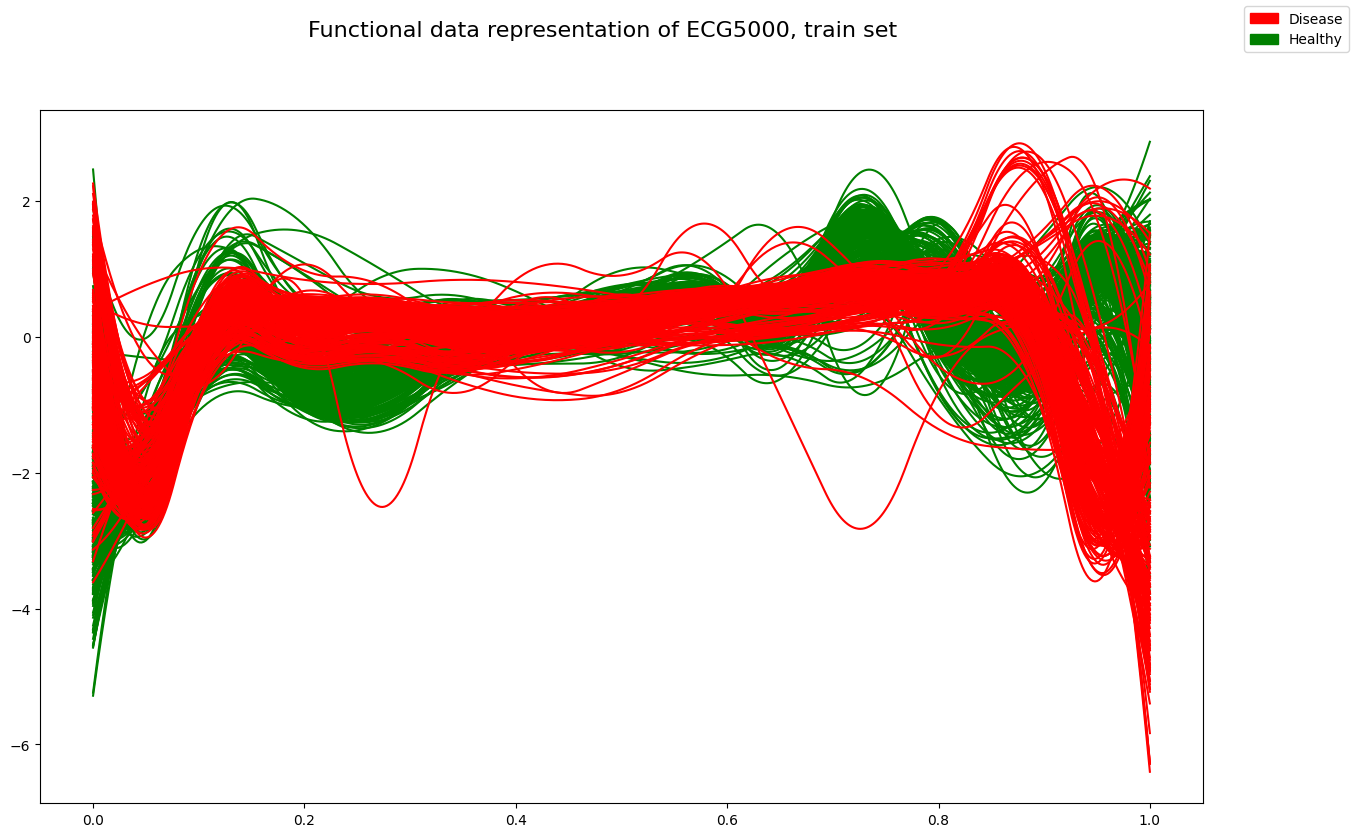

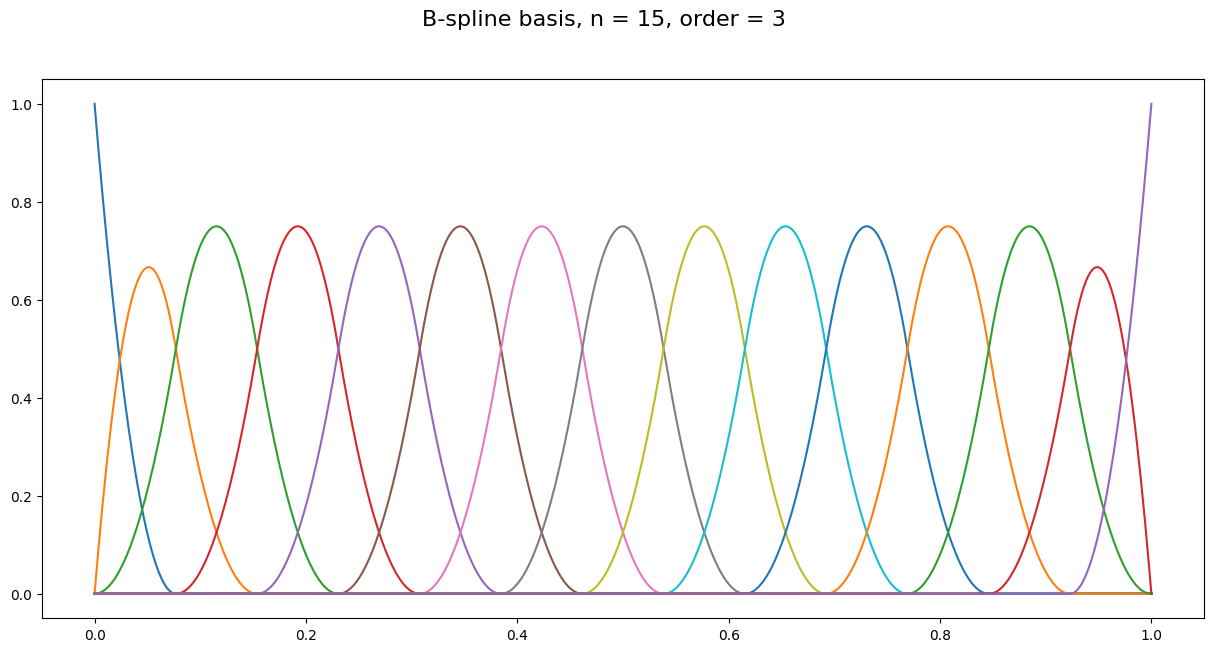

In [4]:

fig = plt.figure(figsize=(15, 9), dpi = 100)
plt.savefig(f'figures/ECG5000_bspline.png' , format='png')
basis = BSpline(n_basis=15, order = 3)
X_train_FDA = FDataBasis.from_data(X_train, grid_points= np.linspace(0, 1, 140), basis=basis)
X_test_FDA = FDataBasis.from_data(X_test, grid_points= np.linspace(0, 1, 140), basis=basis)

X_train_FDA.plot(fig = fig, group = y_train, group_colors = ['red', 'green'], group_names = ['Disease', 'Healthy'])
fig.suptitle(f'Functional data representation of ECG5000, train set', fontsize=16)
plt.savefig(f'figures/ECG5000_bspline2.png' , format='png')
fig2 = plt.figure(figsize=(15, 7), dpi = 100)
fig2.suptitle(f'B-spline basis, n = 15, order = 3', fontsize=16)
basis.plot(fig = fig2 )
plt.savefig(f'figures/Bspline_basis.png' , format='png')

# Training a XGBoost Classifier

XGBoost, raw data
Number of features:  140
Accuracy: 0.9764


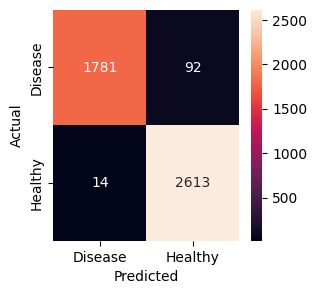

In [5]:
#create a XGBoost classifier
def train_xgb(X_train, y_train, X_test, y_test):
    from xgboost import XGBClassifier
    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    from sklearn.metrics import accuracy_score
    print('Number of features: ', X_train.shape[1])
    print('Accuracy:', accuracy_score(y_test, pred).round(4))
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_test, pred)
    fig, ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt='d',
        xticklabels=['Disease', 'Healthy'],
        yticklabels=['Disease', 'Healthy'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

print('XGBoost, raw data')
train_xgb(X_train, y_train, X_test, y_test)





XGBoost, functional data
Number of features:  15
Accuracy: 0.9811


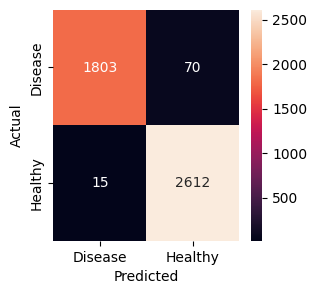

In [6]:
print('XGBoost, functional data')
train_xgb(X_train_FDA.coefficients, y_train, X_test_FDA.coefficients, y_test)


XGBoost, functional data w/ derivatives
Number of features:  42
Accuracy: 0.9867


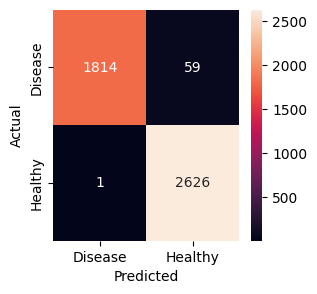

In [7]:
X_train_FDA_derivatives = np.concatenate([
    X_train_FDA.coefficients,
    X_train_FDA.derivative().coefficients,
    X_train_FDA.derivative().derivative().coefficients
    ], axis = 1)

X_test_FDA_derivatives = np.concatenate([
    X_test_FDA.coefficients,
    X_test_FDA.derivative().coefficients,
    X_test_FDA.derivative().derivative().coefficients
    ], axis = 1)

print('XGBoost, functional data w/ derivatives')
train_xgb(X_train_FDA_derivatives, y_train, X_test_FDA_derivatives, y_test)

